# Optimize

run and compare optimization frameworks
- scipy.optimize (L-BFGS-B)
- Dlib
- Pptuna
- Hyperopt
- Platypus
- Nevergrad
- Ax


In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from functools import partial
# import pandas_datareader as pdr
from concurrent import futures

import pytest
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# optimizers
from scipy import optimize
import dlib     # http://dlib.net/
import optuna   # https://optuna.org/
import hyperopt # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
import platypus    # https://github.com/Project-Platypus/Platypus
from platypus import MOEAD, Problem, Real
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
import ax  # https://ax.dev/

from SWRsimulation import SWRsimulationCE
from SWRsimulation.crra_ce import crra_ce

# TODO:
# check strategies that have some exhaustion in report but doesn't show up in histogram
# visualize show all metrics in dataframe
# fun swr end to end with all the optimized strategies

# 2) montecarlo - initialize array of trials at start and reuse it

# 3) take strategies for 0 and 1 and double check the CE values because it seems off. check strat 1 at CE 0 and strat 0 at CE1
# redo history several times without reinitializing with different parameters
# simulates take override simulation args
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them

# 4) add chart of all spending paths

# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time

# 4) do with deathrate

# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))
print("%s %s" % ("dlib", dlib.__version__))
print("%s %s" % ('optuna', optuna.__version__))
print("%s %s" % ('hyperopt', hyperopt.__version__))
print("%s %s" % ("platypus", platypus.__version__))
print("%s %s" % ("nevergrad", ng.__version__))
print("%s %s" % ("ax", ax.__version__))


numpy 1.19.5
pandas 1.2.1
scipy 1.6.0
dlib 19.21.1
optuna 2.5.0
hyperopt 0.2.5
platypus 1.0.4
nevergrad 0.4.3
ax 0.1.19


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


### Load data

Data via Aswath Damodaran (thanks professor!)

http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html 

In [4]:
# load Damodaran data from pickle

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011522
1929,-0.082979,0.030179,0.000000
1930,-0.251236,0.005398,-0.026712
1931,-0.438375,-0.156808,-0.089321
1932,-0.086424,0.235896,-0.103014
...,...,...,...
2016,0.117731,0.103651,0.012616
2017,0.216055,0.097239,0.021301
2018,-0.042269,-0.027626,0.024426


In [5]:
# should adjust CPI to year-ending also but leave it for now (seems to be annual avg index vs prev year avg)
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454874,0.044227
1929,-0.082979,0.030179
1930,-0.230686,0.032991
1931,-0.383290,-0.074106
1932,0.018495,0.377832
...,...,...
2016,0.103805,0.089901
2017,0.190692,0.074354
2018,-0.065104,-0.050811


### Function to optimize 

In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    # global s   # for debugging keep last
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulationCE.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'smoothing_factor': 1.0,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with functools.partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


### scipy.optimize (L-BFGS-B)

In [25]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

results_dict = {}
timings_dict = {}

# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time
    study_timings.append(time_elapsed.total_seconds())

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))
        

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

2021-02-14 21:51:41 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations max
2021-02-14 21:51:45 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.747913
2021-02-14 21:51:45 best value -15532.416056, best params [0.         6.20410477 1.        ]
2021-02-14 21:51:45 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations max
2021-02-14 21:51:52 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 11 iterations in 0:00:06.988907
2021-02-14 21:51:52 best value -13517.859788, best params [0.29529652 6.23943231 1.        ]
2021-02-14 21:51:52 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations max
2021-02-14 21:52:58 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 14 iterations in 0:01:06.377062
2021-02-14 21:52:58 best value -12036.308515, best params [2.06403558 4.39369665 1.        ]
2021-02-14 21:52:58 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations max
2021-02-14 21:55:33 Finishing optimizer scipy.optimize (L-

In [26]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value,timing
0,0,1.000000,0.000000,0.000000,6.204105,-15532.416056,3.747913
1,1,1.000000,0.000000,0.295297,6.239432,-13517.859788,6.988907
2,2,1.000000,0.000000,2.064036,4.393697,-12036.308515,66.377062
3,4,0.890329,0.109671,2.615586,3.199853,-10318.960483,155.449216
4,6,0.816224,0.183776,3.000151,2.265994,-9574.406303,43.068221
5,8,0.785915,0.214085,3.188369,1.833849,-9163.997255,57.019691
6,10,0.770464,0.229536,3.322693,1.534553,-8906.921628,68.261596
7,12,0.902841,0.097159,2.662793,3.077798,-7980.752323,50.241880
8,14,0.753637,0.246363,3.498058,1.154462,-8603.485064,85.214279
9,16,0.754680,0.245320,3.556900,1.029995,-8506.558108,41.944025


Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f842ef320b0>}

Allocation:
{'asset_weights': array([0.75468013, 0.24531987])}

Withdrawal:
{'fixed': 3.5568999701583297,
 'fixed_pct': 3.5568999701583293,
 'variable': 0.01029994504412624,
 'variable_pct': 1.029994504412624}


,metric,value
0,mean annual spending over all cohorts,5.26486292
1,mean within-cohort standard deviation of spending,0.63743776
2,lowest annual spending over all cohorts,3.59391712
3,minimum ending portfolio over all cohorts,0.0000005
4,minimum ending portfolio in years,[1966]
5,% cohort portfolios exhausted by final year,0.0


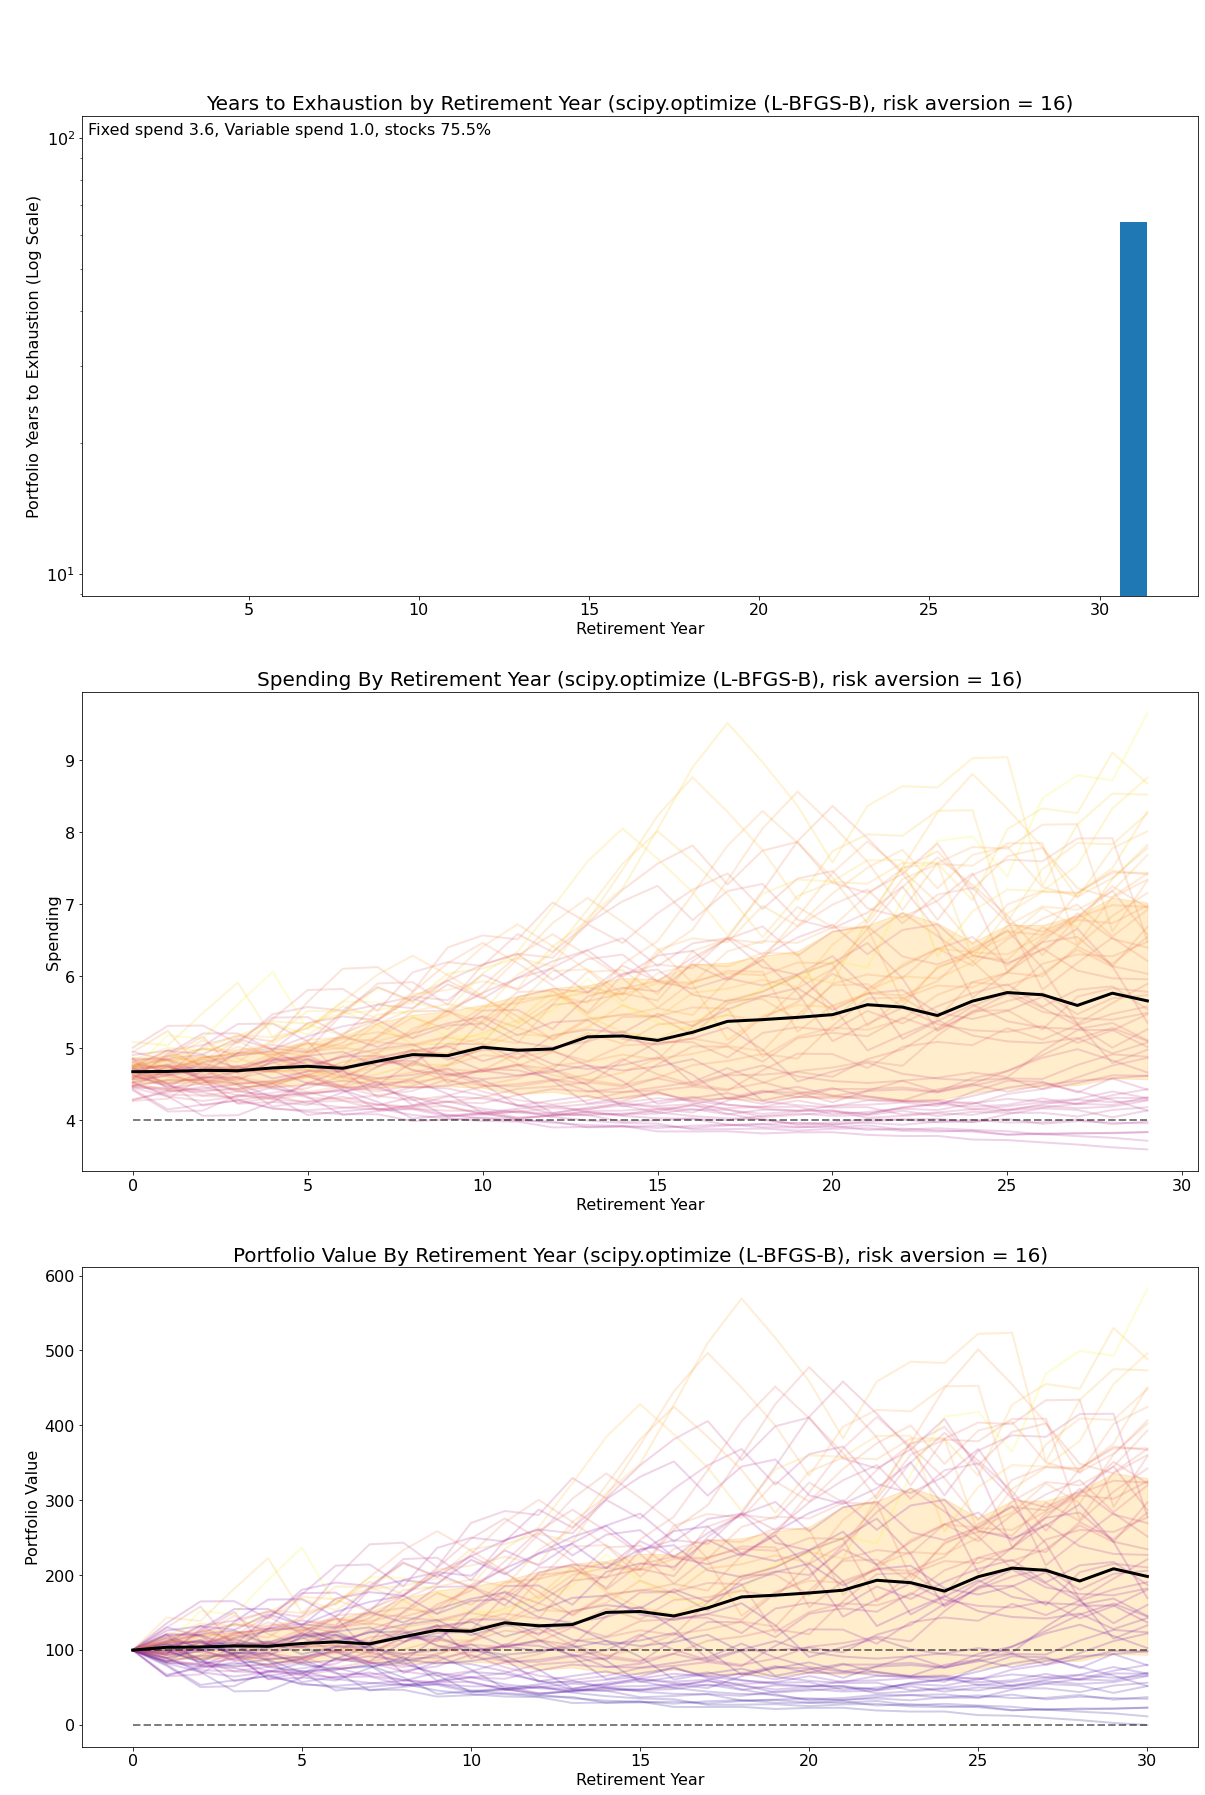

In [34]:
def run_strategy(resultsrow, verbose=True):

    FIXED_SPEND = resultsrow.fixed_spend
    VARIABLE_SPEND = resultsrow.variable_spend
    ALLOC_STOCKS = resultsrow.alloc_stocks
    ALLOC_BONDS = 1 - ALLOC_STOCKS
    GAMMA = resultsrow.gamma
    N_RET_YEARS = 30

    s = SWRsimulationCE.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': N_RET_YEARS,
                      },
        'allocation': {'asset_weights': np.array([ALLOC_STOCKS, ALLOC_BONDS])}, # default is equal-weight 
        'withdrawal': {'fixed_pct': FIXED_SPEND,
                       'variable_pct': VARIABLE_SPEND},
        'evaluation': {'gamma': GAMMA},
        'visualization': {'histogram': True, 
                          'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                       'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                               VARIABLE_SPEND, 
                                                                                                               100 * ALLOC_STOCKS)
                                      },
                          'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                          'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                         }    
    })
    
    if verbose:
        print(s)

    s.simulate()

    return s
    

run_strategy(results.iloc[-1]).visualize()


In [20]:
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %s params %s" % (datestr(), best[1], best[0]))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

dlib 19.21.1
2021-02-14 21:49:36 Starting dlib, gamma 0, 1000 trials


KeyboardInterrupt: 

In [19]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


ValueError: Length of values (0) does not match length of index (10)

In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Optuna

https://optuna.org/


In [ ]:
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))    

In [ ]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Hyperopt
http://hyperopt.github.io/hyperopt/

In [ ]:
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study_params[-1]))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

In [ ]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
study_values = []

for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Platypus
https://github.com/Project-Platypus/Platypus

In [ ]:
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results

In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Nevergrad
https://facebookresearch.github.io/nevergrad/optimization.html

In [ ]:
print("%s %s" % ("nevergrad", ng.__version__))

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


### Ax
https://ax.dev/

In [ ]:
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 3  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed.total_seconds())
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

In [ ]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


In [ ]:
run_strategy(results.iloc[-1]).visualize()


In [ ]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



### Visualize combined results

In [ ]:
# plot all results

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, selected optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
# for opt in results_dict.keys():
# skip last 2 which are more messy and never best
# maybe they need more iterations but they are taking plenty of time already
for opt in ['scipy.optimize (L-BFGS-B)', 'dlib', 'Optuna', 'Hyperopt', 'Platypus (MOEAD)', 'Nevergrad (OnePlusOne)']:
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [ ]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']



In [ ]:
mean_spends = []
exhaustions = []
minimum_spends = []

for row in all_results.itertuples():
    s = run_strategy(row, verbose=False)
    mean_spends.append(np.mean([z['mean_spend'] for z in s.latest_simulation]))
    exhaustions.append(np.mean([z['years_to_exhaustion'] for z in s.latest_simulation]))
    minimum_spends.append(np.min([z['min_spend'] for z in s.latest_simulation]))
    
all_results['mean_spend'] = mean_spends
all_results['min_spend'] = minimum_spends
all_results['exhaustion'] = exhaustions
all_results['ce_annual_spend'] = all_results['value'] / N_RET_YEARS / (len(real_return_df) - N_RET_YEARS + 1)

In [ ]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
top_results = all_results.loc[all_results['value'] == all_results['group_gamma_max']].sort_values('gamma')
top_results.to_pickle('topresults.pickle')
top_results

In [ ]:
top_results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend', 'mean_spend', 'min_spend', 'ce_annual_spend', 'optimizer',]]

In [ ]:
pd.DataFrame(timings_dict.values(), index=timings_dict.keys(), columns=['timing'])

In [ ]:
print([z['exhaustion'] for z in s.latest_simulation])
print(np.min([z['min_end_port'] for z in s.latest_simulation]))
s.latest_simulation[38]['trial'].index[0]

In [ ]:
i = 5
FIXED_SPEND = all_results.iloc[i].fixed_spend
VARIABLE_SPEND = all_results.iloc[i].variable_spend
ALLOC_STOCKS = all_results.iloc[i].alloc_stocks
ALLOC_BONDS = all_results.iloc[i].alloc_bonds
GAMMA  = all_results.iloc[i].gamma
optimizer = all_results.iloc[i].optimizer

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([ALLOC_STOCKS, ALLOC_BONDS])}, 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND,
                  },
    'evaluation': {'gamma': GAMMA},
    'visualization': {'histogram': True, 
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                   'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                           VARIABLE_SPEND, 
                                                                                                           100 * ALLOC_STOCKS)
                                  },
                      'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                  },
                      'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                  },
                     }    
    
})

print(s)
s.simulate()
s.visualize()

# ignore params and get from table
# run_strategy(all_results.iloc[6]).visualize()


In [ ]:
## 38
y2e = [z['years_to_exhaustion'] for z in s.latest_simulation]
y2e[38]
s.latest_simulation[38]['trial']

In [ ]:
# rank by year
cohort_years = []

for i in range(N_RET_YEARS):
    cohort_years.append([c['trial'].iloc[i]['spend'] for c in s.latest_simulation ])

cohort_spend = np.array(cohort_years)
cohort_spend.shape

In [ ]:
np.min(cohort_spend, axis=1)
np.max(cohort_spend, axis=1)
np.median(cohort_spend, axis=1)
np.quantile(cohort_spend, .25, axis=1)
np.quantile(cohort_spend, .75, axis=1)

In [ ]:
timings_dict

In [ ]:
s0 = run_strategy(results.iloc[0], verbose=False)
# check one iteration
print("%-20s %.6f" % ('mean_spend', s0.latest_simulation[0]['mean_spend']))
print("%-20s %.6f" % ('mean of spend', s0.latest_simulation[0]['trial']['spend'].mean()))
print("%-20s %.6f" % ('ce_spend', s0.latest_simulation[0]['ce_spend'] / N_RET_YEARS))
print("%-20s %.6f" % ('ce of spend', crra_ce(s0.latest_simulation[0]['trial']['spend'], 0) / N_RET_YEARS))
# -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), 0)

# check all iterations
print("%-20s %.6f" % ("mean of mean_spend", np.mean([z['mean_spend'] for z in s0.latest_simulation])))
print("%-20s %.6f" % ("mean of ce_spend", np.mean([z['ce_spend'] for z in s0.latest_simulation]) / N_RET_YEARS))
print("%-20s %.6f" % ("total ce_spend", crra_ce(np.array([z['ce_spend'] for z in s0.latest_simulation]), 0) / N_RET_YEARS / (len(real_return_df) - N_RET_YEARS + 1)))
